# Modeling

In [2]:
# general Imports
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import sys

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,3)

# Preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Neural Network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
from keras.callbacks import CSVLogger

# import helper functions
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *

print(tf.__version__)

2.0.0


Using TensorFlow backend.


# Set Parameters and directories to save models

## Parameters

In [3]:
model_id = 'Multi_input'
number_of_images = 15000
EPOCHS = 30
neurons_per_dense = 1024
dense_layers = 2
open_layers = 2
penalty_weight = 10
csv = '../1_cleaning/metadata_cleaned3.csv'

# Preprocessing

In [7]:
# One hot encode all the categorical variables, and get the image paths
X_train_images, X_val_images, X_train_hier, X_val_hier, y_train_bin, y_val_bin, features = train_test_split_custom_2(number_of_images)

In [8]:
# Create image pipeline and create dataset to feed model
dataset_multi_train = create_dataset_multi(X_train_images,X_train_hier, y_train_bin)
dataset_multi_val = create_dataset_multi(X_val_images,X_val_hier, y_val_bin)

## Directories

### File naming conventions
Files should be saved in the following convention, which is outlined in the readme file
model#_sample_size#_epoch#_dense#_trainable_layers_loss_function

In [9]:
# Create the name of the model
name_of_model = 'model_' + model_id + \
                '_sample_size_' + str(number_of_images) + \
                '_epoch_' + str(EPOCHS) + \
                '_dense_' + str(dense_layers) + \
                '_neurons_' + str(neurons_per_dense) + \
                '_losswbc_' + \
                '_num_open_layers_' + str(open_layers) + \
                '_penalty_weight_' + str(penalty_weight)

# Send everything to the efs
base_path = '/home/ubuntu/efs/models/'
    
# Directories for checkpoint
checkpoint_path = base_path + 'Checkpoints/' + name_of_model + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# For training history
csv_logger = CSVLogger(base_path + 'Training_history/' + name_of_model + "_history_log.csv", append=True)
training_history_path = base_path + 'Training_history/' + name_of_model + '.pickle'

# For model saving once training has ended
saved_model_path = base_path + 'Saved_models/' + name_of_model + '.h5'

# Model Image path
model_image_path = base_path + 'Model_image/' + model_id + '.png'


# Model set-up

## Setup the VGG19 pretrained network as seperate model

In [10]:
num_label = y_train_bin.shape[1]

In [12]:
# Setup the single layer Dense as it's own model
# define two sets of inputs
inputA = Input(shape=(224,224,3))
inputB = Input(shape=X_train_hier.shape[1], name="hier")
# the first branch operates on the first input
x = VGG19(include_top=False, weights='imagenet')(inputA)
x = Flatten()(x)
x = Dense(neurons_per_dense, activation='relu', name='fc_1')(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(32, activation='relu', name = 'fc_hier')(inputB)
y = Dense(32, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(neurons_per_dense, activation="relu")(combined)
z = Dropout(.2)(z)
z = Dense(num_label, activation="sigmoid")(z)
z = Model(inputs=[x.input, y.input], outputs=z)



In [13]:
LR = 1e-5
optimizer = Adam(lr=LR)
loss = weighted_bce
metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]

z.compile(optimizer=optimizer, 
          loss=loss, 
          metrics=metrics)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
tf.keras.utils.plot_model(
    z,
    to_file=model_image_path,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

img = mpimg.imread(model_image_path)
plt.imshow(img)


plt.figure(figsize=(20,10))

In [10]:
# Setup the multi-input model from https://www.programcreek.com/python/example/89660/keras.layers.concatenate


def getMultiModel():
    
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

    transfer_layer = vgg.get_layer('block5_pool')

    # cutting of the end of the model before the dense layers
    conv_model = Model(inputs=vgg.input,
                       outputs=transfer_layer.output)

    # Setup Trainable layers
    conv_model.trainable = False if open_layers < 1 else True

    for layer in conv_model.layers[:-(open_layers+1):]:
        layer.trainable =  False
    
    x = conv_model.output
    

    x = Flatten()(x)
    
    x = Dense(512, activation='relu', name='fc_1')(x)
    
    input_2 = Input(shape=X_train_hier.shape[1], name="hier")
    
    hier_layer = Dense(32, activation='relu', name = 'fc_hier')(input_2)
    
    merge_one = concatenate([x, hier_layer])
    
    merge_one = Dense(512, activation='relu', name='fc_2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(num_label, activation='sigmoid')(merge_one)
    
    # Define the models
    model = Model(inputs=[conv_model.input, input_2], outputs=predictions)
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model 


In [11]:
multi_input_model = getMultiModel()

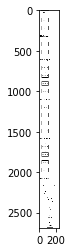

In [13]:
tf.keras.utils.plot_model(
    multi_input_model,
    to_file=model_image_path,
    show_shapes=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

img = mpimg.imread(model_image_path)
plt.imshow(img)

In [12]:
# multi_input_model.summary()

In [14]:
print_layer_trainable(multi_input_model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten
True:	hier
True:	fc_1
True:	fc_hier
True:	concatenate
True:	fc_2
True:	dropout
True:	dense


In [15]:
multi_input_model.trainable

True

## Create a callback checkpoint 

In [16]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = multi_input_model.fit(dataset_multi_train,
                    epochs=EPOCHS,
                    validation_data=dataset_multi_val,
                    callbacks=[cp_callback,
                               csv_logger,
                               #sanity_check_callback,
                              ])

## Load old weights?

In [43]:
# Loads the weights from the checkpoint path above
# new_model.load_weights(checkpoint_path)

## Create the datasets (incl. image pre-processing, resizing, putting into batches)

## Save history and model

In [18]:
# Save the training history

pickle.dump(history.history, open(training_history_path, 'wb'))

# Save the model
multi_input_model.save(saved_model_path)

In [19]:
saved_model_path

'/home/ubuntu/efs/models/Saved_models/model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5'